In [1]:
import requests, pandas as pd, re, time, html

def clean_comment(text):
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)
    text = re.sub(r"<.*?>", " ", text)                       # remove HTML tags
    text = re.sub(r"http\S+|www\.\S+", " ", text)           # remove URLs
    text = re.sub(r"^\s*>\s*", "", text, flags=re.MULTILINE) # remove greentext markers
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)            # keep only letters/numbers/space/' 
    text = re.sub(r"\s+", " ", text).strip()                # normalize whitespace

    return text

boards = ["pol", "g", "x", "lit"]

keywords = [
    "god","spirit","religion","christian","christ","jesus","atheism","muslim",
    "psychosis","angel","demon","dream","reality","ascend","ascension",
    "spiral","ritual","core","aesthetic","glitch","hyper","hyperstition",
    "delusion","meltdown","possessed","entity","ai","ego","death","void",
    "unreal","unreality","awake","awaken","awakened","simulation","matrix",
    "occult","prophecy","signal","frequency"
]


conflictual_terms = [
    "war","fight","battle","race war","civil war","kill","killing","genocide",
    "collapse","uprising","revolt","revolution","clash","conflict","enemy",
    "destroy","destruction","violence","blood","crusade","holy war"
]

revelatory_terms = [
    "revelation","reveal","revealed","prophecy","prophetic","vision","visions",
    "awaken","awakened","awakening","ascend","ascension","enlighten",
    "enlightened","truth","hidden truth","redpill","redpilled","see clearly",
    "veil","unveiled","message from","sign","omen"
]

resignationist_terms = [
    "blackpill","blackpilled","doomed","lost cause","pointless","no hope",
    "nothing matters","void","meaningless","inevitable","can't change",
    "give up","resign","resignation","accept fate","over","we lost"
]

def categorize_post(subject, comment):
    text = f"{subject} {comment}".lower()

    scores = {
        "conflictual": 0,
        "revelatory": 0,
        "resignationist": 0
    }

    for term in conflictual_terms:
        if term in text:
            scores["conflictual"] += 1

    for term in revelatory_terms:
        if term in text:
            scores["revelatory"] += 1

    for term in resignationist_terms:
        if term in text:
            scores["resignationist"] += 1

    max_cat = max(scores, key=scores.get)
    if scores[max_cat] == 0:
        return "uncategorized"

    return max_cat


matches = []

for board in boards:
    catalog_url = f"https://a.4cdn.org/{board}/catalog.json"
    catalog = requests.get(catalog_url).json()

    for page in catalog:
        for thread in page["threads"]:
            thread_no = thread["no"]

            thread_url = f"https://a.4cdn.org/{board}/thread/{thread_no}.json"
            try:
                thread_data = requests.get(thread_url).json()
            except:
                continue

            for post in thread_data["posts"]:
                raw_comment = post.get("com", "") or ""
                raw_subject = post.get("sub", "") or ""

                comment = clean_comment(raw_comment)
                subject = clean_comment(raw_subject)

                if any(word.lower() in comment.lower() or word.lower() in subject.lower()
                       for word in keywords):
                    
                    category = categorize_post(subject, comment)

                    matches.append({
                        "board": board,
                        "thread_no": thread_no,
                        "post_no": post.get("no"),
                        "subject": subject,
                        "comment": comment,
                        "time": post.get("time"),
                        "category": category
                    })

            time.sleep(0.5)


df = pd.DataFrame(matches)
df["time"] = pd.to_datetime(df["time"], unit="s")

df.to_csv("religious_threads_expanded_cleaned_categorized.csv", index=False)


In [2]:
df

,board,thread_no,post_no,subject,comment,time,category
0,pol,523047840,523048038,,523047840 Congralations murican Poor me living...,2025-12-07 12:30:26,uncategorized
1,pol,523047840,523048107,,523047881 just move away from your family and ...,2025-12-07 12:32:20,conflictual
2,pol,523047840,523048184,,523047932 Painfully earnest Bad thing Huh,2025-12-07 12:34:05,uncategorized
3,pol,523047840,523048275,,523047840 I hope home prices never go down aga...,2025-12-07 12:36:11,uncategorized
4,pol,523047840,523048607,,523048107 current president MAYBE Just MAYBE T...,2025-12-07 12:46:21,resignationist
...,...,...,...,...,...,...,...
9048,lit,24926007,24929187,,Since I got divorced I've been living in a roo...,2025-12-06 07:15:44,uncategorized
9049,lit,24926007,24929209,,24929110 Being jobless and living in a shithol...,2025-12-06 07:41:49,uncategorized
9050,lit,24926007,24929391,,24929007 Yeah I lived like this for a couple y...,2025-12-06 10:37:57,uncategorized
9051,lit,24926007,24929398,,24929209 Yeah it's fucked up If you're in Euro...,2025-12-06 10:40:57,resignationist


In [3]:
df["category"].value_counts()

category
uncategorized     5842
conflictual       1664
revelatory         802
resignationist     745
Name: count, dtype: int64

In [4]:
df["board"].value_counts()

board
x      2935
pol    2402
g      1983
lit    1733
Name: count, dtype: int64

In [5]:
conflictual = df['category'] == 'conflictual'

In [6]:
df[conflictual]

,board,thread_no,post_no,subject,comment,time,category
1,pol,523047840,523048107,,523047881 just move away from your family and ...,2025-12-07 12:32:20,conflictual
5,pol,523050241,523050241,uhg Ukraine Happening General 18612,Previous 523015387 Day 1 382 Daily assessment ...,2025-12-07 13:29:22,conflictual
10,pol,523050241,523050475,,523049576 practice has shown that there are ma...,2025-12-07 13:35:23,conflictual
11,pol,523050241,523050490,,523050254 this was autopublished on the state ...,2025-12-07 13:35:41,conflictual
15,pol,523050241,523050923,,It's interesting how an article about a Russia...,2025-12-07 13:47:24,conflictual
...,...,...,...,...,...,...,...
9027,lit,24925037,24930363,,24930343 Yes I'm white with blonde hair and gr...,2025-12-06 20:10:42,conflictual
9029,lit,24925037,24930383,,24930357 I'm going to pretend I didn't read th...,2025-12-06 20:15:32,conflictual
9031,lit,24925037,24930389,,24930383 and also have to explain to you why t...,2025-12-06 20:18:22,conflictual
9041,lit,24925037,24930484,,your thoughts never ending cycle of horny want...,2025-12-06 20:47:13,conflictual


In [7]:
revelatory = df['category'] == 'revelatory'

In [8]:
resignationist = df['category'] == 'resignationist'

In [9]:

from collections import Counter

texts = df["comment"].dropna().tolist()

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower().strip()
    return text

cleaned_texts = [clean_text(t) for t in texts]


In [10]:


vocab = {
    "god","angel","demon","dream","reality","ascend","ascension",
    "spiral","ritual","core","aesthetic","glitch","hyper","hyperstition",
    "psychosis","delusion","meltdown","possessed","entity","ai","ego",
    "death","void","unreal","unreality","awake","awaken","awakened",
    "simulation","matrix","occult","prophecy","signal","frequency"
}

words = [
    w for w in " ".join(cleaned_texts).split()
    if w.lower() in vocab
]

word_counts = Counter(words)
for word, count in word_counts.most_common(40):
    print(word, count)

god 1195
ai 774
reality 433
death 341
dream 158
demon 97
core 96
angel 77
simulation 72
ritual 65
occult 62
signal 61
entity 60
matrix 60
ego 46
unreal 41
frequency 38
aesthetic 34
possessed 32
prophecy 31
delusion 30
void 25
hyper 25
spiral 17
meltdown 13
psychosis 13
awake 13
ascend 9
awakened 7
ascension 6
awaken 6
glitch 3
hyperstition 2
unreality 1


In [11]:

rows = []

for cat in ["conflictual", "revelatory", "resignationist"]:
    subset = df[df["category"] == cat]
    words = " ".join(subset["comment"].astype(str)).split()
    filtered = [w.lower() for w in words if w.lower() in vocab]

    counts = Counter(filtered)
    for word, count in counts.items():
        rows.append({"category": cat, "word": word, "count": count})

freq_df = pd.DataFrame(rows)
freq_df.sort_values(["category", "count"], ascending=[True, False]).head(20)

pivot = freq_df.pivot_table(
    index="word",
    columns="category",
    values="count",
    fill_value=0
)

pivot.sort_values(by=["conflictual","revelatory","resignationist"], ascending=False).head(20)


category,conflictual,resignationist,revelatory
word,,,
god,338.0,60.0,198.0
ai,137.0,65.0,79.0
death,101.0,27.0,39.0
reality,98.0,48.0,92.0
dream,38.0,9.0,14.0
demon,32.0,4.0,5.0
ritual,21.0,10.0,4.0
core,20.0,11.0,17.0
entity,20.0,3.0,9.0


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 3), min_df=5, stop_words="english")
X = vectorizer.fit_transform(cleaned_texts)
ngrams = vectorizer.get_feature_names_out()

counts = X.sum(axis=0).A1
ngram_freq = sorted(list(zip(ngrams, counts)), key=lambda x: x[1], reverse=True)

for phrase, count in ngram_freq[:30]:
    print(phrase, count)

dont know 158
dont want 107
just like 105
years ago 104
dont think 93
jesus christ 79
feel like 75
look like 66
corona corona 64
dont care 60
ive seen 59
im sure 57
things like 54
dont need 53
flat earth 53
looks like 52
hindu rape 51
long time 50
doesnt matter 49
sounds like 49
corona corona corona 48
make sense 48
makes sense 48
th century 47
dont understand 46
just want 45
im just 44
indian hindu 40
people like 40
dont like 39


In [13]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [14]:
from wordcloud import WordCloud

In [15]:
import matplotlib.pyplot as plt

In [16]:
from wordcloud import STOPWORDS

In [17]:
print(df[revelatory]['comment'])


127     523047717 all white women are traitors the whi...
142     To french anons itt quick question why did the...
156     523048970 This year Russia ordered 2000 Sosna ...
159     The Trump administration has officially enshri...
176     523047904 Eh you have no idea of the mental st...
                              ...                        
9012    24929255 You know they can just go to a Buddhi...
9016    24929331 I seriously doubt that women are capa...
9017    24925037 I think I just unintentionally said t...
9024    It's insane how quickly fascism has re emerged...
9030    It's insane how quickly Republicanism has re e...
Name: comment, Length: 802, dtype: object


In [18]:
text = ' '.join(df['comment'].tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

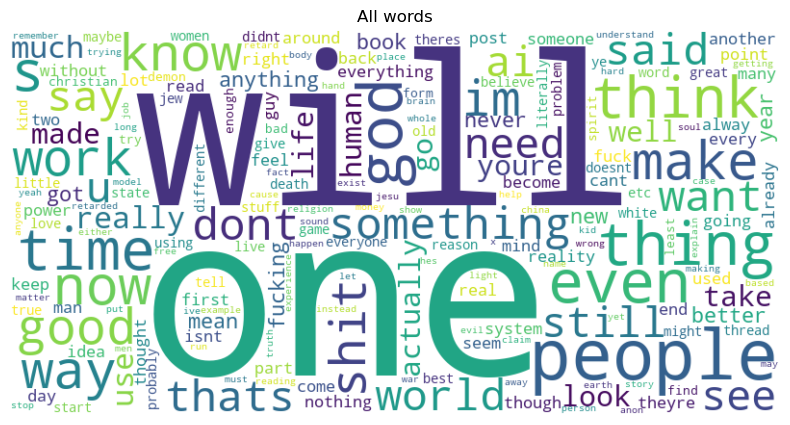

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("All words")
plt.show()

In [20]:
text = ' '.join(df[revelatory]['comment'].tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

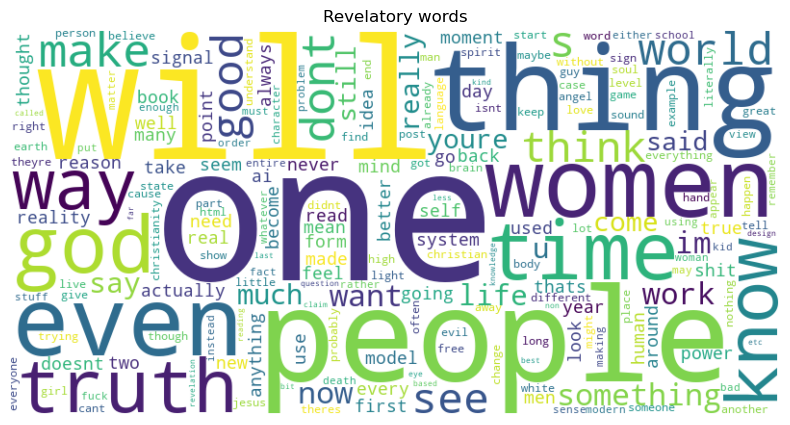

In [21]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Revelatory words")
plt.show()

In [22]:
text = ' '.join(df[conflictual]['comment'].tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

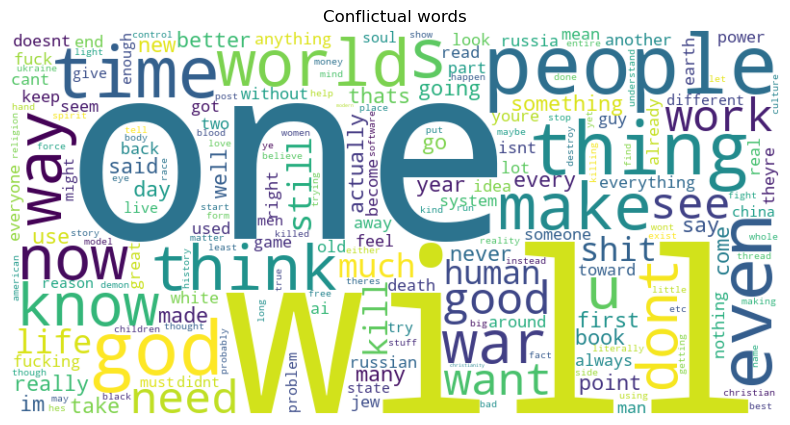

In [23]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Conflictual words")
plt.show()

In [24]:
text = ' '.join(df[resignationist]['comment'].tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

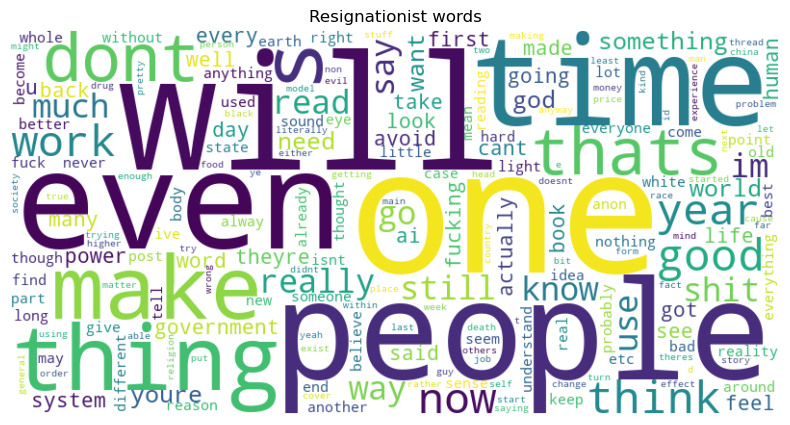

In [25]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Resignationist words")
plt.show()

In [26]:
df[resignationist].to_csv("resignationist_threads.csv", index=False)

In [27]:
df[revelatory].to_csv("revalatory_threads.csv", index=False)

In [28]:
df[conflictual].to_csv("conflictual_threads.csv", index=False)

In [29]:
pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 62.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [sentence-transformers]ence-transformers]
Note: you may need to restart the kernel to use updated packages.


In [30]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(df["comment"].tolist(), convert_to_numpy=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [32]:
import umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine")
points = reducer.fit_transform(embeddings)

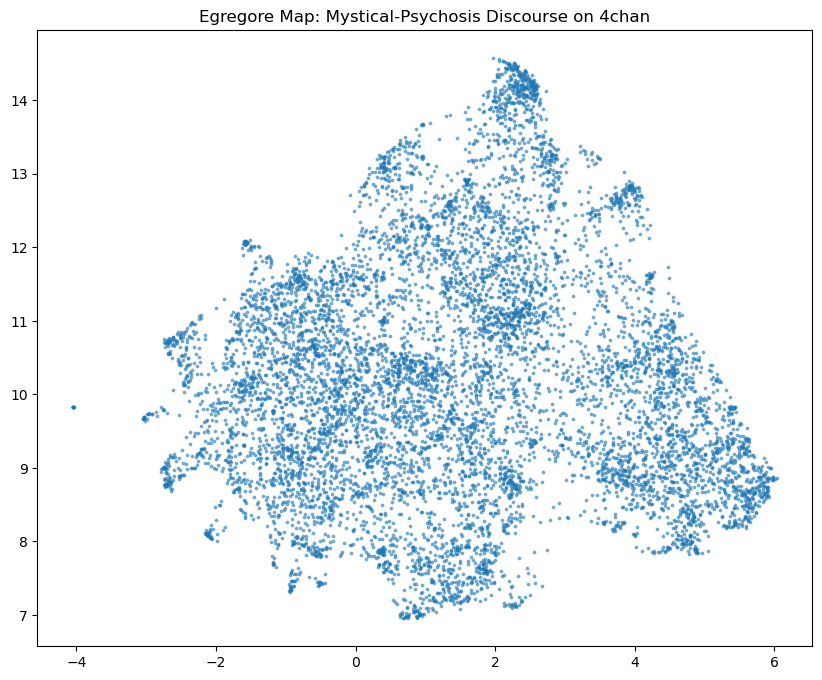

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(points[:,0], points[:,1], s=3, alpha=0.5)
plt.title("Egregore Map: Mystical-Psychosis Discourse on 4chan")
plt.show()

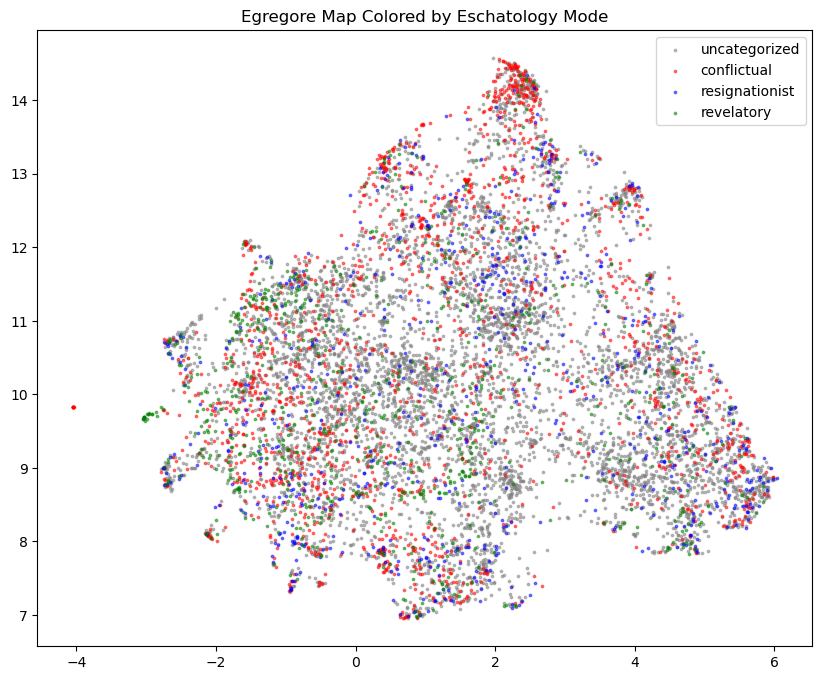

In [34]:
colors = {
    "conflictual": "red",
    "revelatory": "green",
    "resignationist": "blue",
    "uncategorized": "gray"
}

plt.figure(figsize=(10,8))
for cat in df["category"].unique():
    idx = df["category"] == cat
    plt.scatter(points[idx,0], points[idx,1], 
                s=3, alpha=0.5, label=cat, 
                color=colors[cat])

plt.legend()
plt.title("Egregore Map Colored by Eschatology Mode")
plt.show()

In [41]:
from huggingface_hub import login
login()